In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GaussianNoise, Activation
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
#data function for reading and processing the train and test sets
#necessary as an input for the optimisation algorithm
def data():
    #define input processing function
    def process_attributes(df, train, test):
        
        #define and fit the scaler to the full dataset
        cs = MinMaxScaler()
        cs.fit(df_inputs.select_dtypes(np.number))
        
        #scale the numerical input variables
        trainContinuous = cs.transform(train.select_dtypes(np.number))
        testContinuous = cs.transform(test.select_dtypes(np.number))
        
        #uncomment the code below to accommodate for any categorical columns
        zipBinarizer = LabelBinarizer().fit(df["Gender"])
        trainCategorical = zipBinarizer.transform(train["Gender"])
        testCategorical = zipBinarizer.transform(test["Gender"])
        
        # construct our training and testing data points by concatenating
        # the categorical features with the continuous features
        trainX = np.hstack([trainContinuous, trainCategorical])
        testX = np.hstack([testContinuous, testCategorical])
        
        #return the processed train and test sets
        #trainX=trainContinuous
        #testX=testContinuous
        
        # return the concatenated training and testing data
        return (trainX, testX)
    
    #read the excel datasets
    df = pd.read_excel('Cleaned_Dataframe.xlsx')
    df.set_index('Sample',inplace=True)


    #separate cancer markers and input data
    df_outputs= df['Status']
    df_inputs = df.drop('Status',axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_inputs, df_outputs, random_state=100, stratify=df_outputs, test_size=0.3)
    
    #process the input sets
    (X_train_sc, X_test_sc) = process_attributes(df_inputs, X_train, X_test)
    
    #encode the categorical output variables
    #encode categorical outputs
    lb = LabelBinarizer()
    lb.fit(y_train)
    train_outputs= lb.transform(y_train)
    test_outputs= lb.transform(y_test)

    Y_train = to_categorical(train_outputs)
    Y_test = to_categorical(test_outputs)

    return X_train_sc, Y_train, X_test_sc, Y_test, lb

In [3]:
#define model and search space for the optimisation algorithm
def model(X_train_sc, Y_train, X_test_sc, Y_test):
    
    #define ANN model and search space
    def ANN():
        
        #define first two layers, possible alternatives for neurons in each,
        #activation function, and dropout layers
        model=Sequential()
        Dropout_rate={{uniform(0, 0.3)}}
        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))

        model.add(Dense({{choice([8,16, 24, 32, 64])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh'])}}))

        model.add(Dropout(Dropout_rate))
        
        #define output layer of the model
        
        model.add(Dense(2))
        model.add(Activation('softmax'))
        
        #define optimisation algorithm for network training
        optim=tf.keras.optimizers.Adam(learning_rate={{choice([0.005, 0.001])}})
        
        #compile model and return it
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
        
        return model 
    
    #encode and transform labels for model training
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(np.argmax(Y_train,axis=1))
    
    #call the ANN and ddefine training epochs; define batch size alternatives
    net = KerasClassifier(build_fn = ANN,
                                 epochs={{choice([50,100,200])}},
                                 batch_size= {{choice([32,64])}},
                                 verbose = 0)
    model = ANN()
    
    #set up cross-validation scoring, and returned variables
    c = cross_val_score(net,
                    X_train_sc, y,
                    cv= StratifiedKFold(n_splits=5, shuffle=True),
                    scoring='f1').mean()
    print('Test accuracy:', c)
    return {'loss': -c, 'status': STATUS_OK, 'model': model}

In [4]:
#call in data function for test evaluation later
X_train, Y_train, X_test, Y_test, lb = data()

In [5]:
#call the optimisation algorithm
best_run, best_model = optim.minimize(model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=Trials(),
                                      notebook_name='ANN_Optimisation')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.pipeline import Pipeline
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
except:
    pass

try:
    from sklearn.compose import make_column_selector as selector
except:
    pass

try:
    from sklearn.compose import ColumnTransformer
except:
    pass

try:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
except:
    pass

try:
    from sklearn.ensemble import RandomForestClassifier
except:
    pass

try:
    from sklearn.svm import SVC
except:
    pass

try:
    from sklearn import linear_model
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                        
0.5525818690609932                                    
  2%|▏         | 1/50 [02:08<1:45:07, 128.71s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.4870587011082219                                                                  
  4%|▍         | 2/50 [04:25<1:46:45, 133.44s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.5368618560214271                                                                  
  6%|▌         | 3/50 [08:26<2:23:08, 182.74s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.5475796860392494                                                                  
  8%|▊         | 4/50 [09:30<1:44:09, 135.87s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.4942027588630992                                                                  
 10%|█         | 5/50 [10:12<1:16:30, 102.01s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.5383038947786387                                                                  
 12%|█▏        | 6/50 [14:09<1:48:26, 147.87s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.4210158050713935                                                                  
 14%|█▍        | 7/50 [14:47<1:20:04, 111.74s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.5319091886934325                                                                  
 16%|█▌        | 8/50 [15:45<1:06:23, 94.85s/trial, best loss: -0.5525818690609932] 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.5113400135472871                                                                 
 18%|█▊        | 9/50 [19:23<1:31:00, 133.19s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                      
0.48094273427911843                                                                 
 20%|██        | 10/50 [19:54<1:07:45, 101.65s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.49883321027473465                                                                  
 22%|██▏       | 11/50 [20:53<57:42, 88.77s/trial, best loss: -0.5525818690609932]   

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.4851954889682902                                                                
 24%|██▍       | 12/50 [21:47<49:30, 78.17s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
 24%|██▍       | 12/50 [22:46<49:30, 78.17s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



0.5281299626613422                                                                
 26%|██▌       | 13/50 [22:46<44:29, 72.15s/trial, best loss: -0.5525818690609932]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.5787842675120473                                                                
 28%|██▊       | 14/50 [24:37<50:23, 84.00s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.15978646003210972                                                               
 30%|███       | 15/50 [25:11<40:09, 68.84s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.4455471512648546                                                                
 32%|███▏      | 16/50 [27:11<47:49, 84.41s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.4408960269766261                                                                
 34%|███▍      | 17/50 [28:06<41:33, 75.56s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.4134742707309079                                                                
 36%|███▌      | 18/50 [28:44<34:15, 64.24s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.5560813309779051                                                                
 38%|███▊      | 19/50 [29:50<33:22, 64.60s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.5135594517129556                                                                
 40%|████      | 20/50 [33:22<54:26, 108.88s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.5430041791223227                                                                 
 42%|████▏     | 21/50 [34:33<47:13, 97.70s/trial, best loss: -0.5787842675120473] 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.5294786681863953                                                                
 44%|████▍     | 22/50 [36:19<46:42, 100.11s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.5423976243790215                                                                 
 46%|████▌     | 23/50 [37:14<38:57, 86.57s/trial, best loss: -0.5787842675120473] 

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.4987576392153266                                                                
 48%|████▊     | 24/50 [39:06<40:49, 94.20s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.48072057214461433                                                               
 50%|█████     | 25/50 [40:06<35:00, 84.01s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.4872075467925132                                                                
 52%|█████▏    | 26/50 [41:55<36:35, 91.47s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.5209855541534507                                                                
 54%|█████▍    | 27/50 [42:49<30:47, 80.33s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.5683377343909267                                                                
 56%|█████▌    | 28/50 [44:32<31:53, 86.95s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.41559296332522333                                                               
 58%|█████▊    | 29/50 [46:29<33:36, 96.01s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.5223559501783878                                                                
 60%|██████    | 30/50 [48:16<33:03, 99.18s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                    
0.4794615191232766                                                                
 62%|██████▏   | 31/50 [49:58<31:44, 100.25s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.4680709061909555                                                                 
 64%|██████▍   | 32/50 [51:54<31:26, 104.82s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.5480654518600876                                                                 
 66%|██████▌   | 33/50 [53:38<29:37, 104.53s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.5328285277016452                                                                 
 68%|██████▊   | 34/50 [57:13<36:45, 137.81s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.4613173700873367                                                                 
 70%|███████   | 35/50 [58:57<31:55, 127.69s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                     
0.5679302587204366                                                                   
 72%|███████▏  | 36/50 [1:00:42<28:10, 120.75s/trial, best loss: -0.5787842675120473]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5856194523661158                                                                   
 74%|███████▍  | 37/50 [1:04:13<32:02, 147.92s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5311519695148279                                                                   
 76%|███████▌  | 38/50 [1:07:54<33:58, 169.88s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5816078168443909                                                                   
 78%|███████▊  | 39/50 [1:11:17<32:58, 179.89s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5178029830653723                                                                   
 80%|████████  | 40/50 [1:14:47<31:27, 188.78s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.4970476985165517                                                                   
 82%|████████▏ | 41/50 [1:18:36<30:08, 200.94s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5610831054792667                                                                   
 84%|████████▍ | 42/50 [1:20:31<23:21, 175.22s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5002277095613232                                                                   
 86%|████████▌ | 43/50 [1:23:58<21:32, 184.61s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5846501095547939                                                                   
 88%|████████▊ | 44/50 [1:26:04<16:41, 166.92s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.4845037862019178                                                                   
 90%|█████████ | 45/50 [1:27:54<12:29, 149.84s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5017713645082781                                                                   
 92%|█████████▏| 46/50 [1:29:55<09:25, 141.41s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.15969343809875372                                                                  
 94%|█████████▍| 47/50 [1:31:47<06:37, 132.45s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5089627239242323                                                                   
 96%|█████████▌| 48/50 [1:33:38<04:12, 126.03s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5220142746610238                                                                   
 98%|█████████▊| 49/50 [1:35:39<02:04, 124.66s/trial, best loss: -0.5856194523661158]

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '

C:\Users\Alext\anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classifi

Test accuracy:                                                                       
0.5339140718103859                                                                   
100%|██████████| 50/50 [1:37:33<00:00, 117.07s/trial, best loss: -0.5856194523661158]


In [6]:
#display the parameters for the best performing model
print(best_run)

{'Activation': 0, 'Activation_1': 2, 'Dense': 3, 'Dense_1': 4, 'Dropout_rate': 0.16441040323937733, 'batch_size': 0, 'epochs': 2, 'learning_rate': 0}


In [7]:
best_model

In [8]:
#train the model to gt learning curves
batch=[32,64]
ep=[50,100,200]

history = best_model.fit(
    X_train, Y_train,
    batch_size=batch[best_run['batch_size']],
    epochs=ep[best_run['epochs']],
    verbose=1,
    validation_data=(X_test, Y_test),
    shuffle=False)

Epoch 1/200
43/43 [==============================] - 4s 66ms/step - loss: 0.5834 - accuracy: 0.6966 - val_loss: 0.5411 - val_accuracy: 0.7330
Epoch 2/200
43/43 [==============================] - 1s 15ms/step - loss: 0.5217 - accuracy: 0.7341 - val_loss: 0.5197 - val_accuracy: 0.7330
Epoch 3/200
43/43 [==============================] - 1s 17ms/step - loss: 0.5050 - accuracy: 0.7556 - val_loss: 0.5276 - val_accuracy: 0.7245
Epoch 4/200
43/43 [==============================] - 1s 18ms/step - loss: 0.5036 - accuracy: 0.7595 - val_loss: 0.5266 - val_accuracy: 0.7194
Epoch 5/200
43/43 [==============================] - 1s 13ms/step - loss: 0.4943 - accuracy: 0.7525 - val_loss: 0.5378 - val_accuracy: 0.6973
Epoch 6/200
43/43 [==============================] - 1s 24ms/step - loss: 0.4950 - accuracy: 0.7389 - val_loss: 0.5305 - val_accuracy: 0.7024
Epoch 7/200
43/43 [==============================] - 1s 14ms/step - loss: 0.4943 - accuracy: 0.7598 - val_loss: 0.5219 - val_accuracy: 0.7109
Epoch 

43/43 [==============================] - 0s 9ms/step - loss: 0.3708 - accuracy: 0.7881 - val_loss: 0.5150 - val_accuracy: 0.7432
Epoch 116/200
43/43 [==============================] - 0s 10ms/step - loss: 0.3710 - accuracy: 0.8036 - val_loss: 0.4900 - val_accuracy: 0.7398
Epoch 117/200
43/43 [==============================] - 0s 11ms/step - loss: 0.3684 - accuracy: 0.7850 - val_loss: 0.5038 - val_accuracy: 0.7398
Epoch 118/200
43/43 [==============================] - 0s 11ms/step - loss: 0.3744 - accuracy: 0.7834 - val_loss: 0.5418 - val_accuracy: 0.7483
Epoch 119/200
43/43 [==============================] - 0s 11ms/step - loss: 0.3802 - accuracy: 0.7933 - val_loss: 0.5554 - val_accuracy: 0.7194
Epoch 120/200
43/43 [==============================] - 0s 10ms/step - loss: 0.3750 - accuracy: 0.7987 - val_loss: 0.5116 - val_accuracy: 0.7245
Epoch 121/200
43/43 [==============================] - 1s 12ms/step - loss: 0.3857 - accuracy: 0.7941 - val_loss: 0.5157 - val_accuracy: 0.7330
Epoch 1

43/43 [==============================] - 0s 11ms/step - loss: 0.3737 - accuracy: 0.7937 - val_loss: 0.5184 - val_accuracy: 0.7381
Epoch 173/200
43/43 [==============================] - 1s 13ms/step - loss: 0.3754 - accuracy: 0.7840 - val_loss: 0.5435 - val_accuracy: 0.7177
Epoch 174/200
43/43 [==============================] - 0s 12ms/step - loss: 0.3721 - accuracy: 0.7975 - val_loss: 0.5120 - val_accuracy: 0.7483
Epoch 175/200
43/43 [==============================] - 0s 11ms/step - loss: 0.3709 - accuracy: 0.7921 - val_loss: 0.5611 - val_accuracy: 0.7177
Epoch 176/200
43/43 [==============================] - 0s 11ms/step - loss: 0.3839 - accuracy: 0.7927 - val_loss: 0.5416 - val_accuracy: 0.7347
Epoch 177/200
43/43 [==============================] - 1s 15ms/step - loss: 0.3725 - accuracy: 0.8095 - val_loss: 0.4796 - val_accuracy: 0.7398
Epoch 178/200
43/43 [==============================] - 0s 10ms/step - loss: 0.3657 - accuracy: 0.8023 - val_loss: 0.4897 - val_accuracy: 0.7347
Epoch 

In [9]:
#Calculate the labels for the test set
predictions = best_model.predict(X_test)

In [10]:
#evaluate test performance of the model
print(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))

[[311 115]
 [ 40 122]]
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       426
           1       0.51      0.75      0.61       162

    accuracy                           0.74       588
   macro avg       0.70      0.74      0.71       588
weighted avg       0.78      0.74      0.75       588



In [11]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


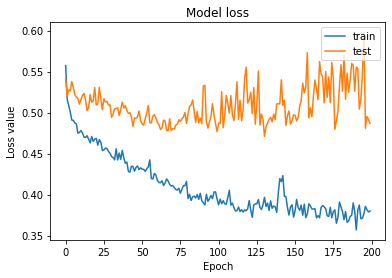

In [12]:
from matplotlib import pyplot as plt
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

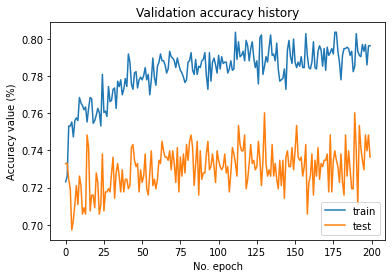

In [13]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [14]:
print('Cancer is encoded by',lb.transform(['Cancer']), ', while Control is encoded by',lb.transform(['Control']))

Cancer is encoded by [[0]] , while Control is encoded by [[1]]
